In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import os
import ast
from shapely import wkt

from his_geo import geocoder

import geopy
from geopy.distance import geodesic
import shapely.geometry
from shapely.geometry import MultiPolygon, Polygon
from shapely.errors import WKTReadingError
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Define Functions

In [32]:
def closeness(x, n):
    if x <= n:
        return (np.cos(x*(np.pi/n))+1)/2
    else:
        return 0

def shapely_point_to_geopy(point_shapely):
    return (point_shapely.y, point_shapely.x)


def calculate_geo_closeness(point1, point2, maximum_error_distance):
    # Geodesic Distance between two points
    point1, point2 = shapely_point_to_geopy(point1), shapely_point_to_geopy(point2)
    distance =  geodesic(point1, point2).kilometers
    # Maximum error distance as cut-off
    n = maximum_error_distance
    # Closeness
    closeness_value = closeness(distance, n)
    return distance, closeness_value


def calculate_geo_closeness_for_all_text(gdf_result, gdf_benchmark):
    # # Check if the number of unique ids in the result is the same as the benchmark
    # if len(gdf_result['id'].unique()) != len(gdf_benchmark['id'].unique()):
    #     print("Number of unique ids in the result is not the same as the benchmark")
    # else:
    gdf_result['error_distance'] = 0.0
    gdf_result['closeness'] = 0.0
    gdf_result['target_toponym'] = None
    # Iterate through each text (section)
    for id in gdf_benchmark['id'].unique():
        gdf_section_benchmark = gdf_benchmark[gdf_benchmark['id'] == id]
        gdf_section_result = gdf_result[gdf_result['id'] == id]

        # Iterate through each extracted toponym
        for index_result, row_result in gdf_section_result.iterrows():
            if len(gdf_section_result) == 0:
                pass
            else:
                result_toponym = row_result['NAME_CH'].replace("县", "").replace("国", "")
                for index_benchmark, row_benchmark in gdf_section_benchmark.iterrows():
                    benchmark_toponym = row_benchmark['NAME_CH'].replace("县", "").replace("国", "")
                    if benchmark_toponym in result_toponym or result_toponym in benchmark_toponym:
                        gdf_result.loc[index_result, 'target_toponym'] = benchmark_toponym
                        if row_result['geometry'] is None or row_result['geometry'].is_empty:
                            distance = None
                            closeness_value = 0
                        else:
                            if row_benchmark['geometry'] is None or row_benchmark['geometry'].is_empty:
                                # Change in the future
                                distance = None
                                closeness_value = 0
                            else:
                                # Get the most accurate level polygon of the benchmark data
                                distance, closeness_value = calculate_geo_closeness(row_result['geometry'], row_benchmark['geometry'], row_result['Maximum Error Distance'])
                                break
                    else:
                        distance = None
                        closeness_value = 0
                # Add the closeness score to the result dataframe
                gdf_result.loc[index_result, 'closeness'] = closeness_value
                gdf_result.loc[index_result, 'error_distance'] = distance

    return gdf_result


def calculate_precision(gdf_result):
    section_precisions = gdf_result.groupby('id')['closeness'].mean()
    total_precision = section_precisions.mean()
    return total_precision


def calculate_scores(gdf_result, gdf_benchmark):

    total_precision = 0
    total_recall = 0
    total_f1 = 0

    for id in gdf_result['id'].unique():
        gdf_section_benchmark = gdf_benchmark[gdf_benchmark['id'] == id]
        gdf_section_result = gdf_result[gdf_result['id'] == id]

        # calculate precision for each section (text)
        section_precision = gdf_section_result['closeness'].mean()
        total_precision += section_precision

        # calculate recall for each section (text)
        section_recall = 0
        for i in range(len(gdf_section_benchmark)):
            benchmark_toponym = gdf_section_benchmark.iloc[i]['NAME_CH'].replace("县", "").replace("国", "")
            if benchmark_toponym not in gdf_section_result['target_toponym'].tolist():
                section_recall += 0
            else:
                section_recall += gdf_section_result[gdf_section_result['target_toponym'] == benchmark_toponym]['closeness'].max()
        section_recall = section_recall / len(gdf_section_benchmark)
        total_recall += section_recall

        # calculate f1 score for each section (text)
        if section_precision == 0 and section_recall == 0:
            section_f1 = 0
        else:
            section_f1 = 2 * section_precision * section_recall / (section_precision + section_recall)
        total_f1 += section_f1

    total_precision = total_precision / len(gdf_result['id'].unique())
    total_recall = total_recall / len(gdf_result['id'].unique())
    total_f1 = total_f1 / len(gdf_result['id'].unique())
   

    return total_precision, total_recall, total_f1

In [33]:
def safe_loads(wkt_string):
    try:
        return wkt.loads(wkt_string)
    except WKTReadingError:
        return None
    
def visualize_dynasty_scores(dynasties, dynasty_scores):
    # Define line styles for different metrics
    metrics = [
               'Accuracy@161km', 
               'Closeness'
               ]
    line_styles = {
        'Accuracy@161km': 'dashed',
        'Closeness': 'solid',
    }

    # Define colors for different levels
    level_colors = ['steelblue', 'yellowgreen']
    level_color_map = {}

    plt.figure(figsize=(10, 6), dpi=300)

    # Iterate over levels and their dynasties
    for idx, (level, dynasties_scores) in enumerate(dynasty_scores.items()):
        color = level_colors[idx % len(level_colors)]
        level_color_map[level] = color

        # Prepare data lists
        mid_years = []
        dynasty_names = []
        metric_values = {metric: [] for metric in metrics}

        for dynasty, scores in dynasties_scores.items():
            if dynasty in dynasties:
                start_year, end_year = dynasties[dynasty]
                mid_year = (start_year + end_year) / 2
                mid_years.append(mid_year)
                dynasty_names.append(dynasty)
                for metric in metrics:
                    metric_values[metric].append(scores[metric])
            else:
                print(f"Warning: Dynasty '{dynasty}' not found in dynasties dictionary.")

        # Sort the data by mid_years
        sorted_data = sorted(zip(mid_years, dynasty_names, *[metric_values[metric] for metric in metrics]))
        if not sorted_data:
            continue  # Skip if there's no data for this level
        mid_years, dynasty_names, *metric_values_sorted = zip(*sorted_data)
        metric_values = {metric: values for metric, values in zip(metrics, metric_values_sorted)}

        # Plot each metric with different line styles
        for metric in metrics:
            plt.plot(mid_years, metric_values[metric],
                     linestyle=line_styles[metric],
                     color=color,
                     marker='o',
                     label=f"{level} - {metric}" if idx == 0 else "")

    # Create custom legends
    level_handles = [mlines.Line2D([], [], color=level_color_map[level], marker='o', linestyle='-', label=level)
                     for level in level_color_map]
    metric_handles = [mlines.Line2D([], [], color='black', linestyle=line_styles[metric], label=metric)
                      for metric in metrics]

    plt.xlabel('Year', fontsize=17)
    plt.ylabel('Scores', fontsize=17)
    plt.ylim(0.700, 1)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(handles=level_handles + metric_handles, loc='best', fontsize=15, ncol=1,
               fancybox=False, edgecolor='black', frameon=True)
    plt.show()


# Geocoding

In [ ]:
files_dir = '../data/evaluation/'
files = [i for i in os.listdir(files_dir) if i.endswith('_wgs84.csv')]
for file in files:
    df = pd.read_csv(files_dir + file, encoding='utf-8-sig')
    addresses = df['PRES_LOC'].tolist()
    geocoder_evaluate = geocoder.Geocoder(addresses, 
                                          lang="ch", 
                                          preferences=['modern'], 
                                          geographic_crs="EPSG:4326", 
                                          if_certainty=True)
    geocoder_evaluate.detect_direction()
    geocoder_evaluate.match_address()
    geocoder_evaluate.calculate_point()
    df_geocoded = geocoder_evaluate.data.reset_index().copy().drop(columns=['id'])
    df = df.reset_index().copy()
    df = df.merge(df_geocoded, left_index=True, right_index=True, how='left')
    df.to_csv(files_dir + file[:-4] + '_geocoded.csv', index=False, encoding='utf-8-sig')


# Evaluation

In [30]:
dynasties = {
             "Han": (-202, 220),
             "Six Dynasties": (222, 589),
             "Sui": (581, 618),
             "Tang": (618, 907),
             "Five Dynasties and Ten Kingdoms": (907, 979),
             "Northern Song": (960, 1127),
             "Southern Song": (1127, 1279),
             "Yuan": (1271, 1368),
             "Ming": (1368, 1644),
             "Qing": (1644, 1911)
             }

In [42]:
file_dir = '../data/evaluation/'
files = [i for i in os.listdir(file_dir) if 'v6_time' in i and i.endswith('geocoded.csv')]

dynasty_scores = {}

for file in files:
    df_result = pd.read_csv(file_dir + file, encoding='utf-8-sig')

    df_benchmark = pd.read_csv(file_dir + file.replace('_geocoded', ''), encoding='utf-8-sig')
    gdf_benchmark = gpd.GeoDataFrame(df_benchmark, geometry=gpd.points_from_xy(df_benchmark.X_COOR, df_benchmark.Y_COOR))
    
    df_result['geometry'] = df_result['geometry'].astype(str)
    df_result['geometry'] = df_result['geometry'].apply(safe_loads)

    gdf_result = gpd.GeoDataFrame(df_result, geometry='geometry')

    gdf_result['id'] = range(len(gdf_result))
    gdf_benchmark['id'] = range(len(gdf_benchmark))

    gdf_result = calculate_geo_closeness_for_all_text(gdf_result, gdf_benchmark)

    gdf_result.to_csv(file_dir + file[:-4] + '_evaluated.csv', encoding='utf-8-sig')

    if 'cnty' in file:
        level = "County-level"
    elif 'pref' in file:
        level = "Prefecture-level"

    print('------All dynasties------')
    df = gdf_result.dropna(subset=['PRES_LOC'])

    total = len(df)
    print('Total:', len(df))

    accuracy_at_161 = np.mean(df['error_distance'] <= 161)
    print('Accuracy@161km:', accuracy_at_161)
    
    closeness_mean = df['closeness'].mean()
    print('Mean closeness:', closeness_mean)

    dynasty_scores[level] = {}
    for dynasty, period in dynasties.items():
        print(f'------{dynasty}------')
        df_filter = df[(df['END_YR'] > period[0]) & (df['BEG_YR'] < period[1])]
        total = len(df_filter)
        print('Total:', len(df_filter))

        accuracy_at_161 = np.mean(df_filter['error_distance'] <= 161)
        print('Accuracy@161km:', accuracy_at_161)

        closeness_mean = df_filter['closeness'].mean()
        print('Mean closeness:', closeness_mean)

        dynasty_scores[level][dynasty] = {}
        dynasty_scores[level][dynasty]["number"] = total
        dynasty_scores[level][dynasty]["Accuracy@161km"] = accuracy_at_161
        dynasty_scores[level][dynasty]["Closeness"] = closeness_mean

------All dynasties------
Total: 10522
Accuracy@161km: 0.9568523094468733
Mean closeness: 0.8126628258417098
------Han------
Total: 2690
Accuracy@161km: 0.9628252788104089
Mean closeness: 0.7873072625718435
------Six Dynasties------
Total: 3019
Accuracy@161km: 0.9589267969526333
Mean closeness: 0.8060079507310915
------Sui------
Total: 2123
Accuracy@161km: 0.9609043805934998
Mean closeness: 0.8127923126956986
------Tang------
Total: 2671
Accuracy@161km: 0.948708348932984
Mean closeness: 0.8202160807891928
------Five Dynasties and Ten Kingdoms------
Total: 1729
Accuracy@161km: 0.9537304800462695
Mean closeness: 0.8287978399204988
------Northern Song------
Total: 1909
Accuracy@161km: 0.9518072289156626
Mean closeness: 0.826502242015949
------Southern Song------
Total: 1878
Accuracy@161km: 0.9637912673056444
Mean closeness: 0.8429730862567885
------Yuan------
Total: 1768
Accuracy@161km: 0.9688914027149321
Mean closeness: 0.84700642230648
------Ming------
Total: 2053
Accuracy@161km: 0.9727

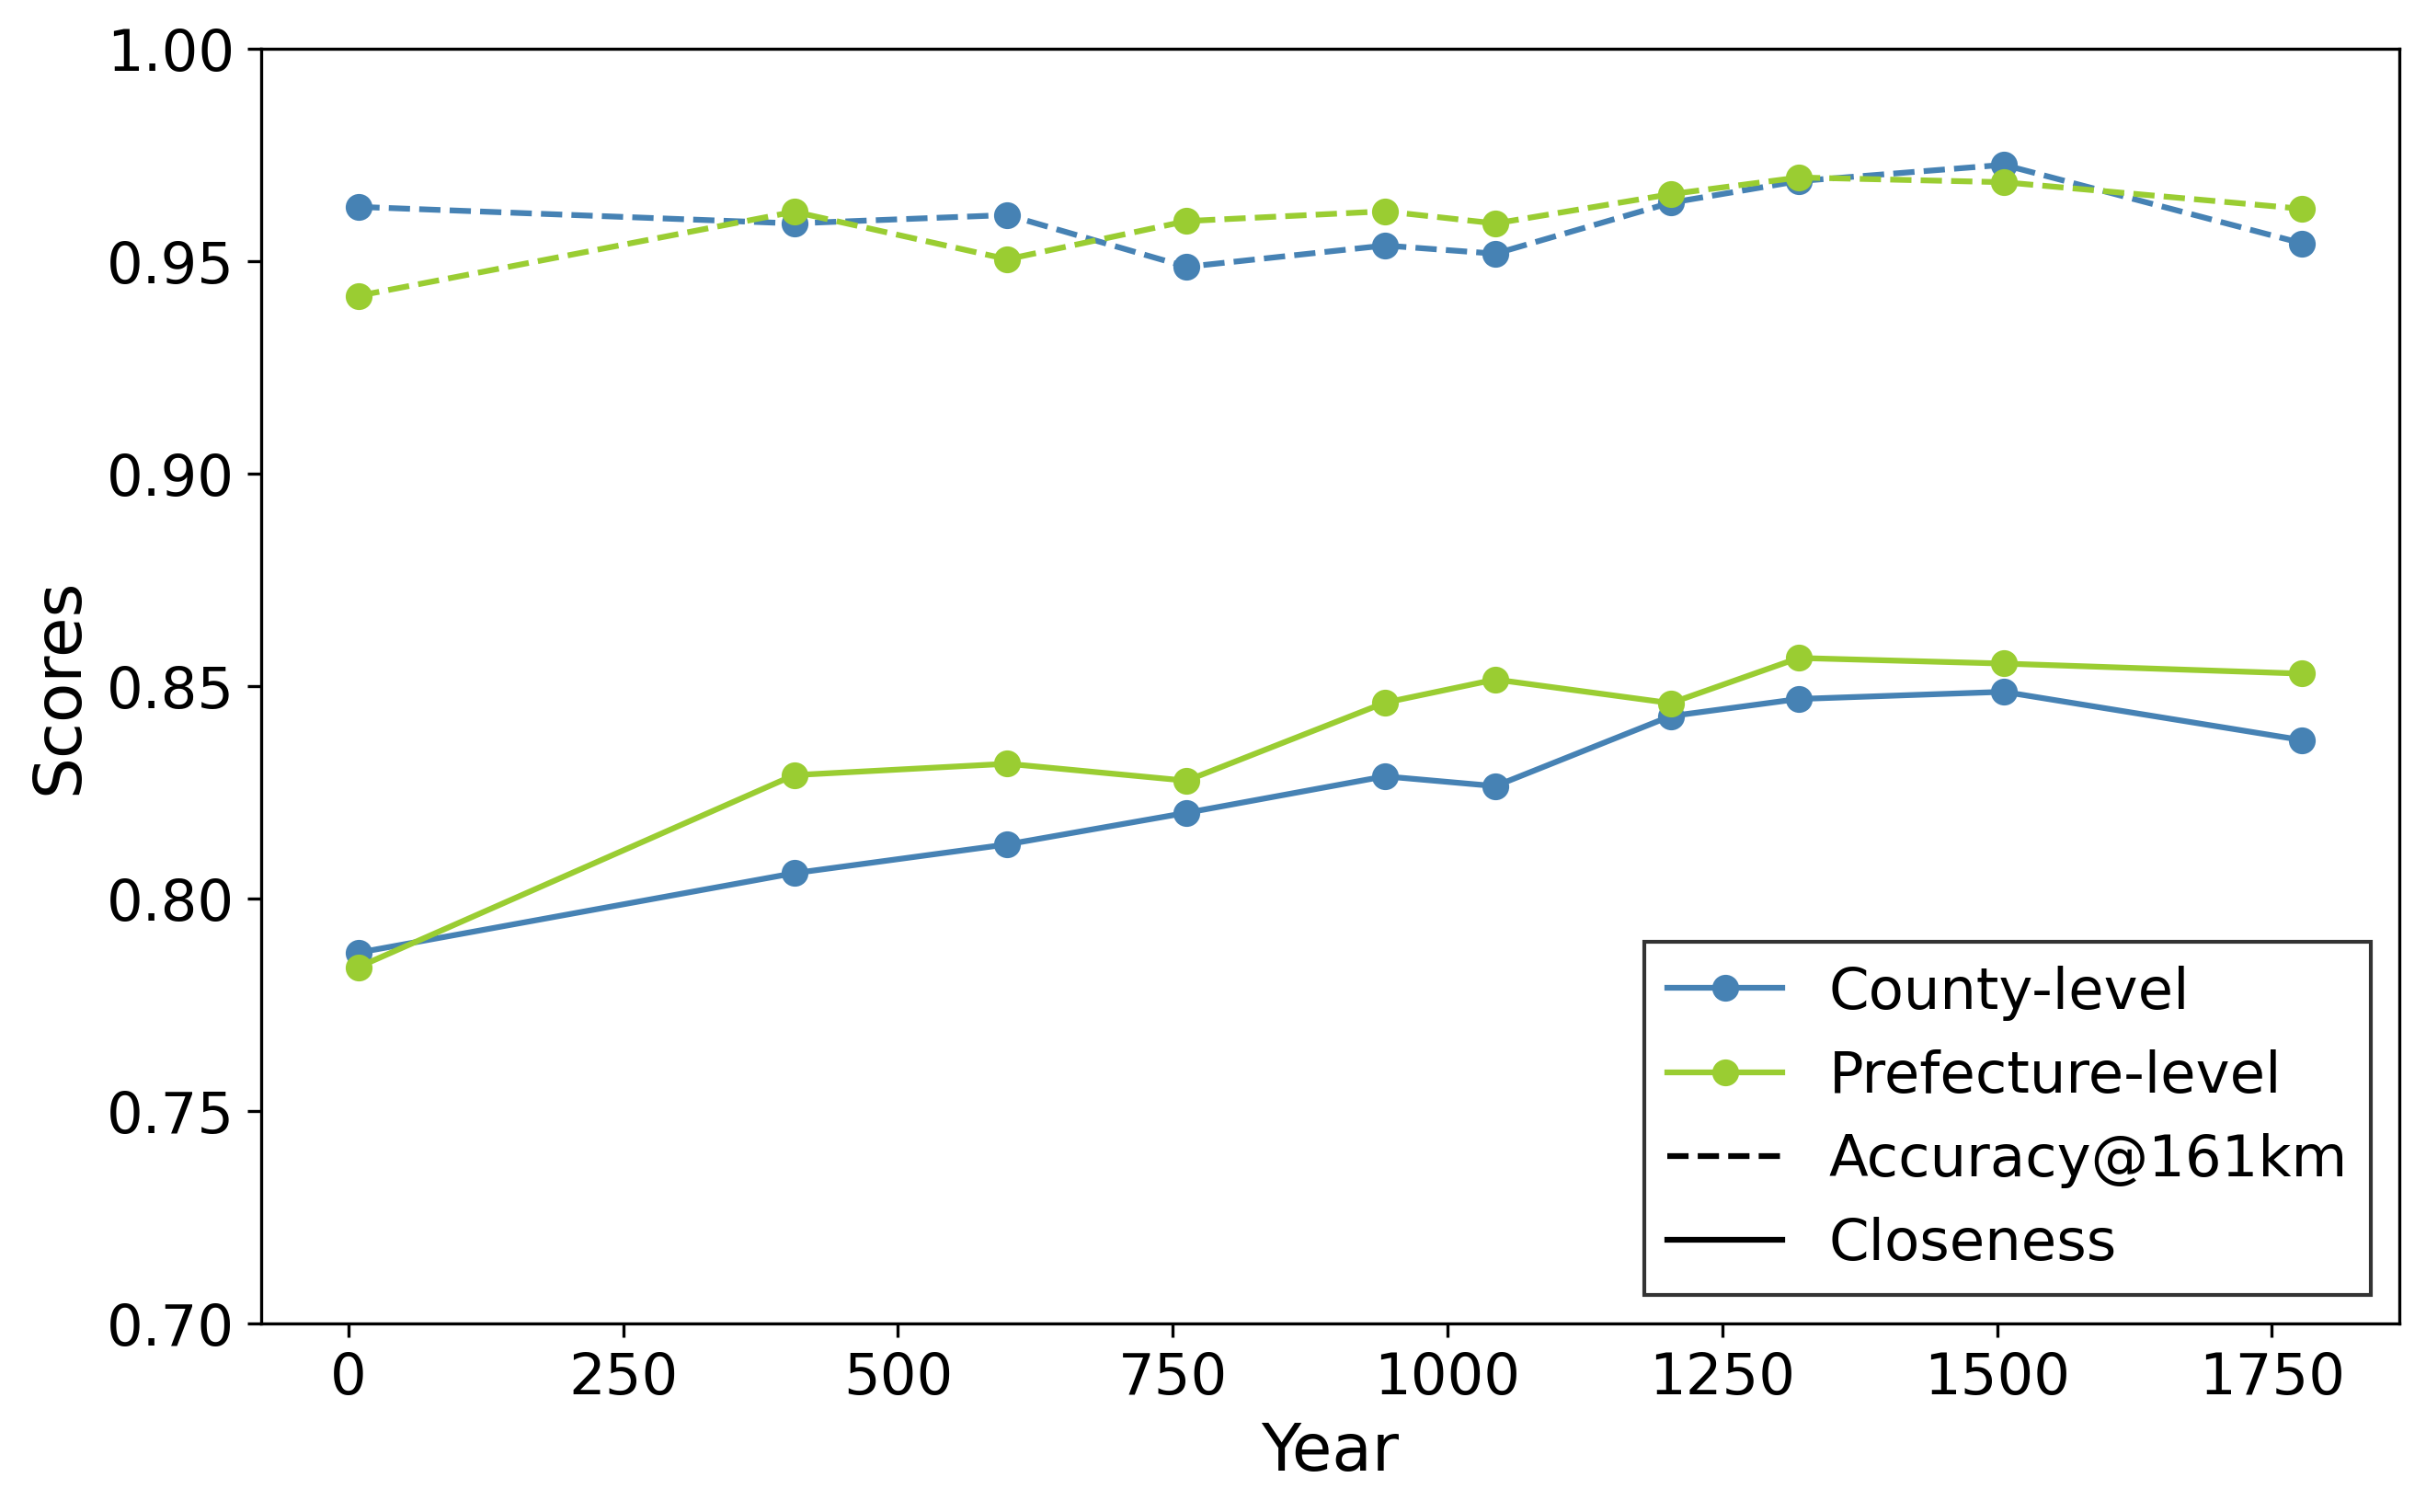

In [44]:
visualize_dynasty_scores(dynasties, dynasty_scores)